<a href="https://colab.research.google.com/github/AudePertron/chromosomes/blob/main/chromos_crossing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided\ UNet++
ls

/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided UNet++


In [ ]:
#loss.py
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

import torch
from torch import nn
from torchvision.transforms import transforms
import torchvision.models as models

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import torchvision.models as models
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import copy
#from loss import *
#from UNet_plus import UNet_plus2 as UNet_plus2
#from utils import *
import argparse
import sys

In [ ]:
#check GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8342392324163919912, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12732197337835394920
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
#initialize model
#Unet_plus.py

import torch
from torch import nn
from torchvision.transforms import transforms
import torchvision.models as models

class DoubleConv(nn.Module):
    # The convolutional layer: conv3-relu-conv3-relu
    def __init__(self, in_ch, mid_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, 3, padding=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class UNet_plus2(nn.Module):
    
    def __init__(self, in_ch=3, out_ch=1):
        super(UNet_plus2, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]

        # Encoder: U-Net
        #self.conv0_0 = nn.Sequential(
        #    nn.Conv2d(in_ch, filters[0], kernel_size=7, stride=1, padding=3,
        #         bias=False),
        #    nn.BatchNorm2d(filters[0]),
        #    nn.ReLU(inplace=True)
        #)
        self.conv0_0 = DoubleConv(self.n_channels, filters[0], filters[0])
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)
        self.conv1_0= DoubleConv(filters[0], filters[1], filters[1])
        self.conv2_0= DoubleConv(filters[1], filters[2], filters[2])
        self.conv3_0= DoubleConv(filters[2], filters[3], filters[3])

        # Upsample layer(Deconv)
        self.up1_0 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(filters[3], filters[2], 2, stride=2)
        self.up1_1 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        self.up1_2 = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)

        # Mid Layer
        self.conv0_1 = DoubleConv(filters[0]*2, filters[0], filters[0]) 
        self.conv1_1 = DoubleConv(filters[1]*2, filters[1], filters[1])
        self.conv2_1 = DoubleConv(filters[2]*2, filters[2], filters[2])

        self.conv0_2 = DoubleConv(filters[0]*2, filters[0], filters[0])
        self.conv1_2 = DoubleConv(filters[1]*2, filters[1], filters[1])

        self.conv0_3 = DoubleConv(filters[0]*2, filters[0], filters[0])

        # attention
        # self.attention0 = ContourAttention(filters[0])
        # self.attention1 = ContourAttention(filters[1])
        
        self.contour = nn.Sequential(
            nn.Conv2d(filters[0] * 2, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.final = nn.Sequential(
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters[0], out_ch, 1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        p = self.pool(x0_0)
        x1_0 = self.conv1_0(p)
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], 1)) + x0_0
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], 1))
        
        x0_2 = self.conv0_2(torch.cat([x0_1, self.up1_1(x1_1)], 1)) + x0_1
        # x1_2 = self.conv1_2(torch.cat([self.attention1(x1_1, x1_0), self.up2_1(x2_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, self.up2_1(x2_1)], 1))
        
        # x0_3 = self.conv0_3(torch.cat([self.attention0(x0_2, x0_0), self.up1_2(x1_2)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, self.up1_2(x1_2)], 1))
        
        contour = self.contour(torch.cat([x0_1, x0_2], dim=1))
        output = self.final(x0_3)

        return self.sigmoid(output), self.sigmoid(contour)

In [ ]:
#load model
model = UNet_plus2(3, 1)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/region-guided UNet++/model.pth'))
model.eval()
print("model loaded")

model loaded


In [ ]:
image = Image.open('/content/gdrive/MyDrive/chromos/base_donnees/outputs/roi29.jpg')
image.shape()

AttributeError: ignored

In [ ]:
#make ready test image
image = Image.open('/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing_partition/img/1.png')
#image = Image.open('/content/gdrive/MyDrive/chromos/base_donnees/outputs/roi29.jpg')
x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image_test = x_transforms(image)

In [ ]:
image_test.shape

torch.Size([3, 256, 256])

In [ ]:
#pred_test = model(image_test[None, ...])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
IMAGE_PATH = '/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing_partition/img'
OVERLAP_PATH = '/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing_partition/crossing'
OTHER_PATH = '/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing_partition/chromosome'

In [ ]:
#predict 
n = "coucou"
with torch.no_grad():
  y = model(image_test[None, ...])
  y_pred_0 = torch.squeeze(y[0]).numpy()
  y_pred = np.zeros((256,256))
  y_pred[y_pred_0 > 0.5] = 1.0
  y_2_0 = torch.squeeze(y[1]).numpy()
  y_2 = np.zeros((256,256))
  y_2[y_2_0 > 0.5] = 1.0
  output1 = np.reshape(y_pred * 255,(256,256))
  output2 = np.reshape(y_2 * 255,(256,256))

  x_image = torch.squeeze(image_test).numpy()
  image = np.dstack((x_image[0,...]*255, x_image[1,...]*255, x_image[2,...]*255))

  cv2.imwrite(OVERLAP_PATH + '/' + str(n) + ".png", output1)

  cv2.imwrite(OTHER_PATH + '/' + str(n) + ".png", output2)
  cv2.imwrite(IMAGE_PATH + '/' + str(n) + ".png", image)

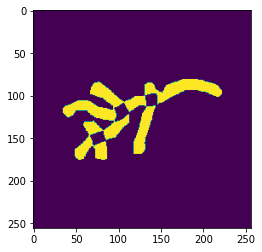

In [ ]:
#visualize
import matplotlib.pyplot as plt
plt.imshow(output2)

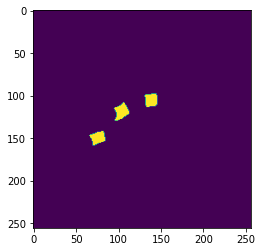

In [ ]:
plt.imshow(output1)

In [ ]:
ls

dataset/              main.py               OVERLAP_PATH0.png       utils.py
IMAGE_PATH0.png       model.pth             OVERLAP_PATHcoucou.png
IMAGE_PATHcoucou.png  OTHER_PATH0.png       __pycache__/
loss.py               OTHER_PATHcoucou.png  UNet_plus.py


## Crossing partitions


In [ ]:
#utils.py
import cv2
from matplotlib import pyplot as plt
import numpy as np
import copy
from skimage import io
import math
import copy
import time
import os

def adjacent(array, x, y, size = 10):
    # 使用这个函数来存储一个像素点的邻近点到一个列表中
    adjacent = []
    for i in range(-size,size+1):
        for j in range(-size,size+1):
            if x+i >= 0 and y+j>=0 and x+i < array.shape[0] and y+j < array.shape[1]:
                adjacent.append((x+i, y+j))
    return adjacent

def dilated_adjacent(array, overlapping_x, overlapping_y, size = 15):
    global _adj
    tmp = np.zeros(array.shape)
    tmp[overlapping_x, overlapping_y] = array[overlapping_x, overlapping_y].copy()
    
    kernel = np.ones((size, size), np.uint8)
    tmp = cv2.dilate(tmp, kernel, iterations=1)
    tmp[overlapping_x, overlapping_y] -= array[overlapping_x, overlapping_y]
    
    # 测试用
#     _adj.append(tmp)
    
    xs, ys = np.where(tmp > 0)
    ret = []
    for x, y in zip(xs, ys):
        ret.append((x, y))
    return ret
    
# 两个函数用来计算两个点连成射线后的点集中是否有可以match的区域
def line_detect(img, point1, point2, sign):
    point1_x, point1_y = point1
    point2_x, point2_y = point2
    if point1_x != point2_x:
        k = float((point1_y - point2_y)/(point1_x - point2_x))
        b = ((point1_y - k*point1_x)+(point2_y - k*point2_x))/2
        for x in range(img.shape[1]):
            y = int(k*x+b)
            if y>=0 and y<img.shape[0]:
                if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                    continue
                else:
                    return img[x,y]
                
        for y in range(img.shape[0]):
            x = int((y-b)/k)
            if x>=0 and x<img.shape[1]:
                if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                    continue
                else:
                    return img[x,y]
    else:
        x = point1_x
        for y in range(img.shape[0]):
            if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                    continue
            else:
                return img[x,y] 
    return 0

def ray_detect(img, point_start, point_end, sign):
    point1_x, point1_y = point_start
    point2_x, point2_y = point_end
    direction_x = point2_x - point1_x
    direction_y = point2_y - point1_y
    if point1_x != point2_x:
        k = float((point1_y - point2_y)/(point1_x - point2_x))
        b = ((point1_y - k*point1_x)+(point2_y - k*point2_x))/2
        if direction_x > 0:
            for x in range(point2_x, img.shape[1]):
                y = int(k*x+b)
                if y>=0 and y<img.shape[0]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_x < 0:
            for x in range(0, point2_x):
                y = int(k*x+b)
                if y>=0 and y<img.shape[0]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_y > 0: 
            for y in range(point2_y, img.shape[0]):
                x = int((y-b)/k)
                if x>=0 and x<img.shape[1]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
        if direction_y < 0: 
            for y in range(0, point2_y):
                x = int((y-b)/k)
                if x>=0 and x<img.shape[1]:
                    if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                        continue
                    else:
                        return int(img[x,y])
    else:
        x = point1_x
        for y in range(img.shape[0]):
            if img[x,y] == 1 or img[x,y] == -1 or img[x,y] == sign:
                continue
            else:
                return int(img[x,y])
    return 0

class UnionFind(object):
    def __init__(self, classes):
        self.__parent = np.concatenate([np.array([0, 1]), classes])
    def find(self, x):
        if x == self.__parent[x]:
            return x
        else:
            self.__parent[x] = self.find(self.__parent[x])
            return self.__parent[x]
    
    def union(self, x, y):
        px, py = self.find(x), self.find(y)
        if (px != py):
            self.__parent[px] = py

def crossing_reconstruct(image, overlapped, non_overlapped):
    ### watershed for crossing areas
    kernel = np.ones((1,1),np.uint8)
    opening_crossing = cv2.morphologyEx(overlapped,cv2.MORPH_OPEN, kernel)
    # sure foreground area
    sure_fg_crossing = cv2.erode(opening_crossing,kernel,iterations=1)
    # sure background area
    sure_bg_crossing = cv2.dilate(opening_crossing,kernel,iterations=1)
    crossing_edge = cv2.subtract(sure_bg_crossing,sure_fg_crossing)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg_crossing)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[crossing_edge == 1] = 0
    markers_crossing = cv2.watershed(image, markers)
    
    # overlapping_class列表存储crossing有的类别，例如，有两个crossing重叠区域，overlapping_class列表中就有两个元素
    overlapping_class = [i for i in range(2, np.max(markers_crossing)+1)]
    overlapping_x_class = {}
    overlapping_y_class = {}
    
    # iterate through all markers values
    for i in overlapping_class:
        overlapping_x_class[i], overlapping_y_class[i] = np.where(markers == i)

    # overlapping_center_class是一个字典，存储每个crossing区域的中点坐标
    overlapping_center_class = {}
    for i in overlapping_class:
        overlapping_center_class[i] = (int(np.mean(overlapping_x_class[i])),int(np.mean(overlapping_y_class[i])))

    # overlapped_areas是crossing区域和相邻size = k的区域的点集，k可以在adjacent函数中调整
    overlapped_areas = {}
    for i in overlapping_class:
        overlapped_areas[i] = dilated_adjacent(overlapped, overlapping_x_class[i], overlapping_y_class[i],
                                   size = 9)
#         radius = int(np.sqrt(len(markers_crossing[markers_crossing == i]) / 2.0))
#         overlapped_areas[i] = adjacent(overlapped, overlapping_center_class[i][0], overlapping_center_class[i][1],
#                                        size = radius)
    
    # 对non-overlapping的部分watershed处理
    ### noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(non_overlapped, cv2.MORPH_OPEN, kernel)

    # sure foreground area
    sure_fg = cv2.erode(opening,kernel,iterations=1)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=2)
    unknown = cv2.subtract(sure_bg,sure_fg)
    sure_fg = np.uint8(sure_fg)

    # Marker labelling
    hole = sure_fg.copy()
    cv2.floodFill(hole,None,(0,0),255) # 找到洞孔
    hole = cv2.bitwise_not(hole)
    ret, markers = cv2.connectedComponents(hole)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    # watershed
    markers = cv2.watershed(image, markers)
    class_num = np.max(markers)
    non_overlapping_class = np.arange(2, class_num + 1)

    # overlapping_match_nonoverlapping是一个字典，用来存储和crossing区域相邻的non-overlapping区域的编号标记
    overlapping_match_nonoverlapping = {}
    for i in overlapping_class:
        overlapping_match_nonoverlapping[i] = set()
        for j in overlapped_areas[i]:
            if markers[j[0], j[1]] > 1:
                overlapping_match_nonoverlapping[i].add(markers[j[0], j[1]])  

    # overlapping_match_nonoverlapping_center用来存储和crossing区域相邻的non-overlapping子区域的区域中心坐标
    overlapping_match_nonoverlapping_center = {}
    for i in overlapping_match_nonoverlapping:
        adj_x, adj_y = zip(*overlapped_areas[i])
        adj_x, adj_y = np.array(adj_x), np.array(adj_y)

        overlapping_match_nonoverlapping_center[i] = {}
        for k in overlapping_match_nonoverlapping[i]:
            k_adj_x = adj_x[np.where(markers[adj_x, adj_y] == k)[0]]
            k_adj_y = adj_y[np.where(markers[adj_x, adj_y] == k)[0]]
            c = (int(np.mean(k_adj_x)), int(np.mean(k_adj_y)))
    #             temp_x, temp_y = np.where(markers == k)
    #             c = (int(np.mean(temp_x)),int(np.mean(temp_y)))
            overlapping_match_nonoverlapping_center[i][k] = c

    # UnionFind for combination
    uf = UnionFind(non_overlapping_class)

    output = copy.deepcopy(markers)
    for i in overlapping_match_nonoverlapping:
        temp_area = np.ones(markers.shape)
        for (x, y) in overlapped_areas[i]:
            temp_area[x, y] = markers[x, y]

        # Ray detect of non-overlapping part in a cycle
        for j in overlapping_match_nonoverlapping_center[i]:
            tag = ray_detect(temp_area, overlapping_match_nonoverlapping_center[i][j], overlapping_center_class[i], j)
            if tag in overlapping_match_nonoverlapping_center[i]:
                uf.union(tag, j)

    chromosome = {}  # dictionary key is non-overlap class for chromosome, value is overlapping region class

    for tag in non_overlapping_class:
        output[output == tag] = uf.find(tag)
        chromosome[uf.find(tag)] = []

    for i in overlapping_class:
        for j in non_overlapping_class:
            if j in overlapping_match_nonoverlapping[i] and i not in chromosome[uf.find(j)]:
                chromosome[uf.find(j)].append(i)  

    cp_image = []
    for i in chromosome:
        mask = np.zeros(output.shape)
        mask[(output == i)] = 1
        for j in chromosome[i]:
            mask[markers_crossing == j] = 1
        cp_image.append(mask)
        
    return cp_image

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import copy
from skimage import io
import math
import copy
import time
from utils import *

IMG_SIZE = 256

OUTPUT_PATH = '/content/gdrive/MyDrive/chromos/base_donnees/ChromSeg/crossing_partition/output'
FILE_NUM = 2

if __name__ == "__main__":
    for i in range(1, FILE_NUM + 1):
        image = cv2.imread(os.path.join(IMAGE_PATH, str(i)+'.png'))
        overlapped = cv2.imread(os.path.join(OVERLAP_PATH, str(i)+'.png'), 0)
        foreground = cv2.imread(os.path.join(OTHER_PATH, str(i)+'.png'), 0)
        non_overlapped = np.zeros(overlapped.shape)
        # kernel = np.ones((1,1),np.uint8)
        # overlapped = cv2.dilate(overlapped,kernel,iterations=1)
        overlapped[overlapped == 255] = 1
        non_overlapped[(overlapped == 0) & (foreground == 255)] = 1   # calculate non-overlapping mask 

        output = crossing_reconstruct(image, overlapped, non_overlapped)

        output_path = os.path.join(OUTPUT_PATH, str(i))
        if not os.path.exists(output_path):
            os.mkdir(output_path)

        cv2.imwrite(os.path.join(output_path, "crossing_" + str(i)+".png"), image)

        try:
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            num = 0
            for mask in output:
                img = copy.deepcopy(gray)
                new_mask = np.zeros((IMG_SIZE, IMG_SIZE))
                for i in range(0, IMG_SIZE):
                    for j in range(0, IMG_SIZE):
                        if(mask[i,j] == 1):
                            for x in range(-1,2):
                                for y in range(-1,2):
                                    try:
                                        new_mask[i+x,j+y] = 1
                                    except:
                                        continue

                img[(new_mask == 0)] = 255
                cv2.imwrite(os.path.join(output_path, str(num)+".png"), img)
                num += 1
        except:
            raise "error(fail to partition)"